In [55]:
import torch
from torchvision import models
import torch.nn as nn


In [56]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [57]:
class MyResModel(torch.nn.Module):
    def __init__(self):
        super(MyResModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(1024,128),
            nn.ReLU(),
            nn.Linear(128,3)
        )

    def forward(self, x):
        return self.classifier(x)

resnet152 = models.resnet152(pretrained=False)
resnet152.fc = MyResModel()
resnet152 = resnet152.to(device)

print(resnet152)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [58]:
import pathlib
import torchvision.transforms as transforms
import torchvision

train_path = './train'
test_path = './test'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5],  # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5, 0.5, 0.5])
])

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

# CNN Network
print(classes)

['Gravel', 'Sand', 'Silt']


In [59]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152.parameters(), lr=1e-4)

In [60]:
loss_training = []

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    size = 0
    mse = 0.0

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        size+=1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet152(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        mse += loss.item()**2
        if i % 5 == 4:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
            running_loss = 0.0

    loss_training.append(mse/size)
    print(f"[{epoch+1}] MSE: {mse/size:.3f}")
print('Finished Training')


[1,     5] loss: 0.997
[1,    10] loss: 0.821
[1,    15] loss: 0.907
[1,    20] loss: 1.141
[1,    25] loss: 0.877
[1,    30] loss: 1.041
[1,    35] loss: 0.538
[1] MSE: 0.895
[2,     5] loss: 1.072
[2,    10] loss: 1.128
[2,    15] loss: 0.815
[2,    20] loss: 0.824
[2,    25] loss: 0.716
[2,    30] loss: 0.607
[2,    35] loss: 1.072
[2] MSE: 0.908
[3,     5] loss: 0.631
[3,    10] loss: 0.911
[3,    15] loss: 1.023
[3,    20] loss: 0.782
[3,    25] loss: 0.593
[3,    30] loss: 1.078
[3,    35] loss: 0.584
[3] MSE: 0.740
[4,     5] loss: 0.536
[4,    10] loss: 0.896
[4,    15] loss: 0.957
[4,    20] loss: 1.134
[4,    25] loss: 0.988
[4,    30] loss: 1.127
[4,    35] loss: 0.978
[4] MSE: 1.079
[5,     5] loss: 0.810
[5,    10] loss: 0.821
[5,    15] loss: 0.665
[5,    20] loss: 1.059
[5,    25] loss: 0.577
[5,    30] loss: 0.773
[5,    35] loss: 0.819
[5] MSE: 0.805
[6,     5] loss: 0.723
[6,    10] loss: 0.853
[6,    15] loss: 0.756
[6,    20] loss: 0.717
[6,    25] loss: 0.770
[6,  

In [61]:
PATH = './soil_net_resnet.pth'
torch.save(resnet152.state_dict(), PATH)

In [62]:
import numpy as np
def movingAverage(data):
    # Calculate a simple moving average with a window size of 3
    window_size = 3
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


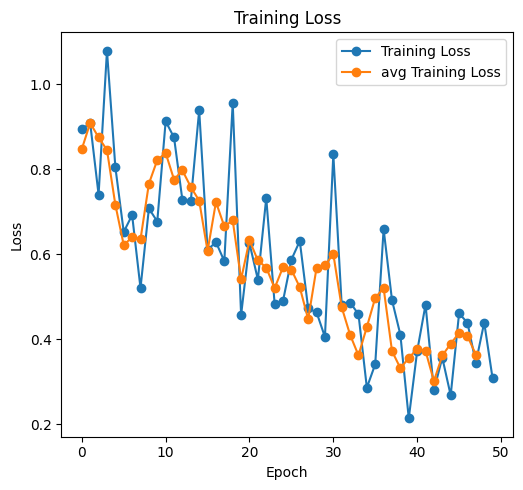

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(loss_training, label='Training Loss', marker='o')
plt.plot(movingAverage(loss_training), label='avg Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
PATH = './cifar_net_resnet_152.pth'
torch.save(resnet152.state_dict(), PATH)

In [65]:
netTest = models.resnet152(pretrained=True)

netTest.fc = MyResModel()

netTest.load_state_dict(torch.load(PATH))

netTest = netTest.to(device)

In [66]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels =  data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = netTest(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 15 test images: {100 * correct // total} %')

Accuracy of the network on the 15 test images: 83 %


In [67]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels =  data[0].to(device), data[1].to(device)
        outputs = netTest(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Gravel is 83.3 %
Accuracy for class: Sand  is 83.3 %
Accuracy for class: Silt  is 83.3 %
